　ModelingToolkitやTuringなどのJuliaの道具がマーケティング的な発想と分析にどのように活用できるのかを試し、多くの人に利用してもらうことでユーザーの幅を広げることを目的としている。パッケージの詳細についてはそれぞれのマニュアルを参照されたい。ModelingToolkitは「微分方程式を記号的に扱う」パッケージで、TuringはMCMCという乱数発生アルゴリズムを利用し「パラメータを推定するパッケージ」という程度の理解でよい。

私の興味は産業の隆盛（ブーム）と衰退のメカニズムであり、ここでは具体例として「パチンコ」を取り上げる。1993年以降のパチンコユーザー調査を利用する。データは日本生産性本部の「レジャー白書」を参照している。

In [1]:
using CSV,StatsPlots,DataFrames

In [2]:
df = CSV.read("pdata.csv", DataFrame)

Row,Year,P_USER,V_PEOPLE
,Int64,Int64,Int64
1,1994,29300,125265
2,1995,29000,125570
3,1996,27600,125859
4,1997,23100,126157
5,1998,19800,126472
6,1999,18600,126667
7,2000,20200,126926
8,2001,19300,126926
9,2002,21700,127316


1994年のプレイヤー人口2930万から持続的に減少し2016年以降は1000万以下が常態となっている。プレイヤーの減少はどこまで続くのだろうか？

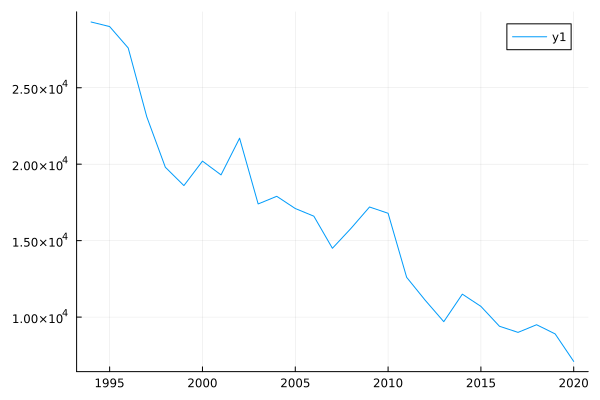

In [3]:
@df df plot(:Year,:P_USER)

In [4]:
using Catalyst,DifferentialEquations,StatsPlots
using ModelingToolkit

人類はパチンコプレイヤーとパチンコをやらない人（「ノンプレイヤー」）に二分される。ここでいう「パチンコプレイヤー」は年間で1回以上ホールで遊戯を行った人と定義される。プレイヤーのほとんどは20代のはじめに（多くは先輩や上司に連れられて）エントリーし、結婚や引っ越し、転職、金融状況、病気、価値観の変化などで遊戯を中断したり再開したりをする。何がプレイを再開させているのかはよくわかっていない。好きなコンテンツやキャラクターがそうさせる場合もあるし、たまたま近所にホールがあったとか、人間関係の変化かもしれない。しかしいずれにしてもそのような理由はプレイヤー・ノンプレイヤー全体に対して一定の確率で発生すると思われる。

プレイヤーはある一定の確率でノンプレイヤーになるし、ノンプレイヤーも一定の確率でプレイヤーになる。この関係を微分方程式に簡単に変換できるツールが　Catalyst.jl　である。はっきり言ってここでは紹介のために使ってみただけだ。

In [5]:
rn = @reaction_network begin
    e, N --> P
    r, P --> N
end

Model ##ReactionSystem#302
States (2):
  N(t)
  P(t)
Parameters (2):
  e
  r

ConvertでODESystemに変換できる。ここで微分方程式のデザインが確認できる

In [6]:
convert(ODESystem, rn)

Model ##ReactionSystem#302 with 2 equations
States (2):
  N(t)
  P(t)
Parameters (2):
  e
  r

パラメータの略語をこのように整理しよう。
### Parameters
 - e =>パチンコ遊戯へのエントリー(entry)の係数
 - r =>パチンコ遊戯を中断(retire)係数
 - b =>人口変動。死亡や誕生（birth）による人口全体の変動係数
 
### Variables
 - N => Non-Player パチンコノンユーザー
 - P => Pachinko Playerパチンコユーザー
 - V => 人口全体（N＋P）

パチンコユーザー<=>ノンユーザーモデルの状態変数とパラメーターを設定する。teventはパラメータや状態に大きな変化を与えるイベント（カタストロフィーイベント catastrophe events）を記述するためだ。

In [7]:
@variables t P(t) V(t) N(t)
@parameters  r e b tevent
D = Differential(t)

(::Differential) (generic function with 3 methods)

微分方程式のモデルを書く。人口の変動分dV(t)は死亡／誕生による差分なので、いずれもノンユーザーとしてモデルに組み込む。

In [8]:
eqs = [ D(P) ~ e * ( V - P )  - r * P
        D(N) ~ r * P  - e *( V - P) + D(V)
        D(V) ~ b
        ]

3-element Vector{Equation}:
 Differential(t)(P(t)) ~ e*(V(t) - P(t)) - r*P(t)
 Differential(t)(N(t)) ~ Differential(t)(V(t)) - e*(V(t) - P(t)) + r*P(t)
 Differential(t)(V(t)) ~ b

## 適当な数字でパラメータを指定してみる

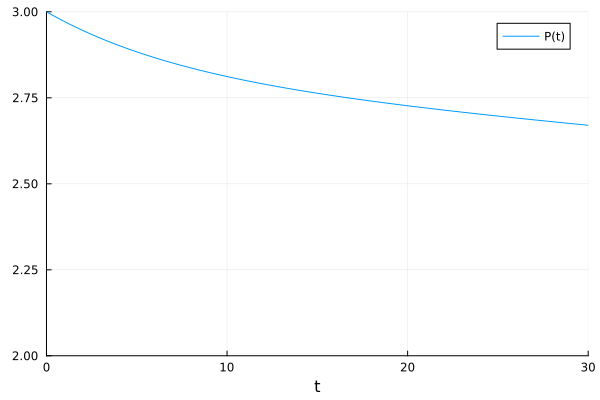

In [9]:
u0 = [P => 3.0 ,N => 9.0, V => 12.0]
ps = [b => -0.02, e => 0.03, r => 0.1]
tspan=(0,30.0)
@named sys = ODESystem(eqs, t)
sys = structural_simplify(sys)

prob = ODEProblem(sys, u0, tspan, ps)
sol = solve(prob)
plot(sol,idxs=[P],ylims=(2,3))

### t=10 と t＝16 で１割のプレイヤーが離脱するカタストロフィーを組み込んだ。

In [10]:
u0 = [P => 3.0 ,N => 9.0, V => 12.0]
ps = [b => -0.02, e => 0.03, r => 0.1]
tspan=(0,30.0)

#discrete_events  = [ (t > 10.0 ) =>  [ e ~ 0, r ~ 0] , (t > 16.0 ) =>  [ e ~ 0.03, r ~ 0.06] ]
event_10 = (t == 10 ) => [ P ~ P * 0.9 ] 
event_16 = (t == 16 ) => [ P ~ P * 0.9 ] 
@named sys_cata = ODESystem(eqs, t, [P,N,V], [b,e,r] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) ;

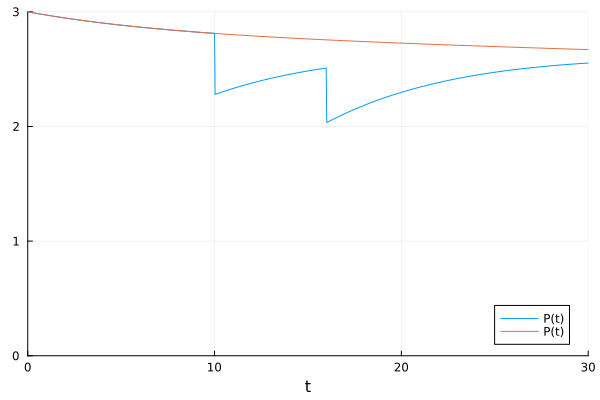

In [11]:
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol2 = solve(prob_cata ;tstops = [10.0, 16.0])
plot(sol2,idxs=[P])
plot!(sol,idxs=[P],ylims=(0,3))

### パラメータが変化しない限り収束点へ回復する

In [12]:
using DataFrames, CSV

## 観測値をもとにモデルのパラメータを発見する

In [13]:
dx = CSV.read(joinpath("p-datasets2.csv"),DataFrame)
for (i,e) in enumerate(names(dx))
    print("$i : $e ,")
end
eq = zeros(31) ; eq[23:end] .= 1.0
dx.eq = eq ;
#dx.パチンコ参加人口 = dx.パチンコ参加人口 .* 10 ;
dx

1 : 年 ,2 : 労働時間 ,3 : 名目賃金 ,4 : 実質賃金 ,5 : 店舗あたり平均台数 ,6 : 証紙発行数 ,7 : 総人口 ,8 : 男女20代 ,9 : 男女30代 ,10 : 男女40代 ,11 : 男女50代 ,12 : 男女60代以上 ,13 : 東京GRP ,14 : 大阪GRP ,15 : 名古屋GRP ,16 : 店舗数 ,17 : パチンコ参加人口 ,

Row,年,労働時間,名目賃金,実質賃金,店舗あたり平均台数,証紙発行数,総人口,男女20代,男女30代,男女40代,男女50代,男女60代以上,東京GRP,大阪GRP,名古屋GRP,店舗数,パチンコ参加人口,eq
,Int64,Float64?,Float64?,Float64?,Float64,Int64?,Int64,Int64,Int64?,Int64?,Int64?,Int64?,Float64?,Float64?,Float64?,Int64,Int64?,Float64
1,1989,missing,missing,missing,193.8,missing,123205,16756,missing,missing,missing,missing,missing,missing,missing,16068,missing,0.0
2,1990,127.1,100.3,111.8,201.1,missing,123611,16923,missing,missing,missing,missing,missing,missing,missing,16074,missing,0.0
3,1991,124.3,104.8,113.1,194.6,missing,124101,17375,missing,missing,missing,missing,missing,missing,missing,17373,missing,0.0
4,1992,121.5,106.9,113.5,189.8,missing,124567,17849,missing,missing,missing,missing,missing,missing,missing,17827,missing,0.0
5,1993,118.2,107.1,112.4,198.0,missing,124938,18301,missing,missing,missing,missing,missing,missing,missing,18036,missing,0.0
6,1994,117.7,108.7,113.6,205.5,missing,125265,18658,missing,missing,missing,missing,missing,missing,missing,18113,29300,0.0
7,1995,117.8,109.9,115.1,209.8,missing,125570,18706,missing,missing,missing,missing,missing,missing,missing,18244,29000,0.0
8,1996,117.9,111.1,116.5,215.1,missing,125859,19130,missing,missing,missing,missing,missing,missing,missing,18164,27600,0.0
9,1997,116.3,112.9,116.4,216.8,missing,126157,19082,missing,missing,missing,missing,missing,missing,missing,17773,23100,0.0


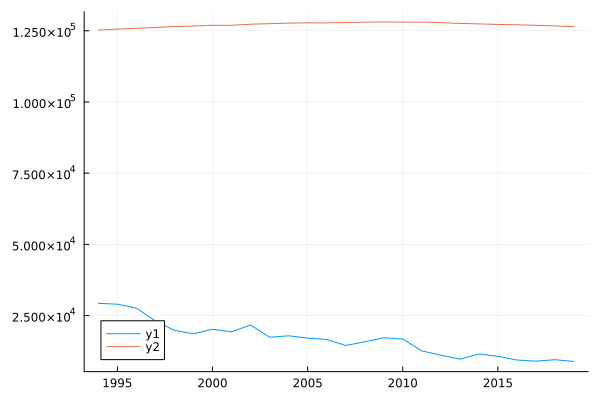

In [14]:
Pu = dx.パチンコ参加人口[6:end]
Vu = dx.総人口[6:end]
year = dx.年[6:end]
plot(year,[Pu,Vu])

In [273]:
"""
    実数時間ｔにおける観測データを返す関数
    serial(3 ; data=ys)
    ys[3]を返す

    tが0の時は無条件にt＝1のデータを返す
"""
function serial(t; data=data) ::Float64
    #t = t +rand(Normal(0.1,0.1))
    if t < 1
        nn = data[1]  + randn()
    else
        #実数と小数点以下とに分ける
        #f, n = divrem(t, 1) divremだとなぜかエラーになる　原因わからず
        f = floor(t)
        n = t - f
        #実数に対応するデータをff、ff+1をffnに入れる
        #ffnはtがデータ時間より長い場合、無条件に最後のデータを返す
        if f >= length(data)
            nn = data[end]  + + randn()
            #nn = (data[t-1  |> Int ] + data[t+1  |> Int ])/2
        else
            ff = data[ f |> Int]
            ffn =data[(f+1) |> Int]
            nn = ff + (ffn - ff) * n
        end
    end

    return nn
end

serial

In [274]:
pu_func(t) = serial(t ; data=Pu)
vu_func(t) = serial(t ; data=Vu)

vu_func (generic function with 3 methods)

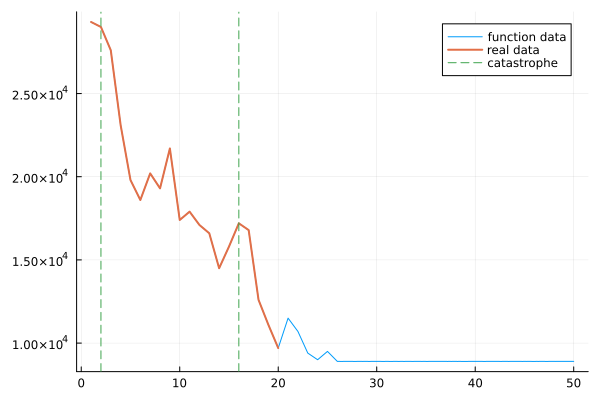

In [275]:
xs = 1:0.2:50
plot(xs,[pu_func(t) for t = xs],label="function data")
plot!(1:20, Pu[1:20],lw=2,label="real data")
vline!([2,16] ,ls=:dash,label="catastrophe")

In [276]:
using Zygote

In [277]:
dvu(τ) = begin
    rs = gradient(x->vu_func(x), τ)[1]
    if rs == nothing 
        (dvu(τ + 0.1) + dvu( τ - 0.1))/2
    else
        rs
    end
end
#dvu(τ) = gradient(x->vu_func(x), τ)[1]

dvu (generic function with 3 methods)

In [278]:
dvu(23.0001) 

-162.0

In [279]:
xs = 1:0.2:23
d_vu =[dvu(t) for t in xs] 

111-element Vector{Float64}:
  305.0
  305.0
  305.0
  305.0
  305.0
  289.0
  289.0
  289.0
  289.0
  289.0
    ⋮
 -177.0
 -177.0
 -177.0
 -142.0
 -142.0
 -142.0
 -142.0
 -142.0
 -162.0

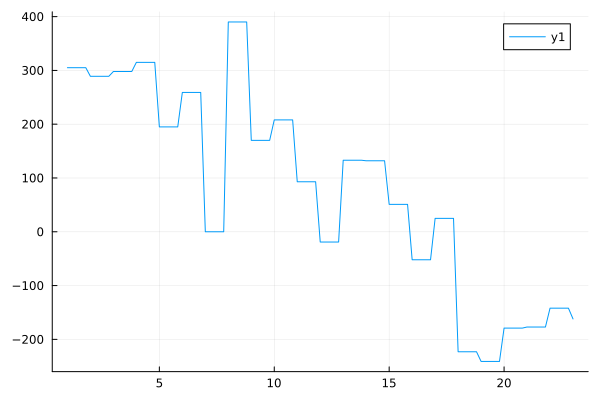

In [280]:
plot(xs, d_vu)

In [281]:
@variables t P(t) V(t) N(t)
@parameters  r e b 
D = Differential(t)

(::Differential) (generic function with 3 methods)

In [282]:
@register_symbolic pu_func(t)
@register_symbolic vu_func(t)
@register_symbolic dvu(t)

## このモデルが正しい

In [283]:
eqs = [ D(P) ~ e * ( V - P )  - r * P
        D(N) ~ r * P  - e *( V - P) + D(V)
        D(V) ~ b
        ]

3-element Vector{Equation}:
 Differential(t)(P(t)) ~ e*(V(t) - P(t)) - r*P(t)
 Differential(t)(N(t)) ~ Differential(t)(V(t)) - e*(V(t) - P(t)) + r*P(t)
 Differential(t)(V(t)) ~ b

In [284]:
u0 = [P => 7.0 ,N => 10.0, V => 10.0]
ps = [b => -0.02, e => 0.25, r=> 0.2]
tspan=(0,30.0)
@named sys = ODESystem(eqs, t)
sys = structural_simplify(sys)

Model sys with 3 equations
States (3):
  P(t)
  V(t)
  N(t)
Parameters (3):
  r
  e
  b
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 7 stored entries:
 ×  ×  ⋅  ×  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ×  ⋅
 ×  ×  ⋅  ⋅  ⋅  ×

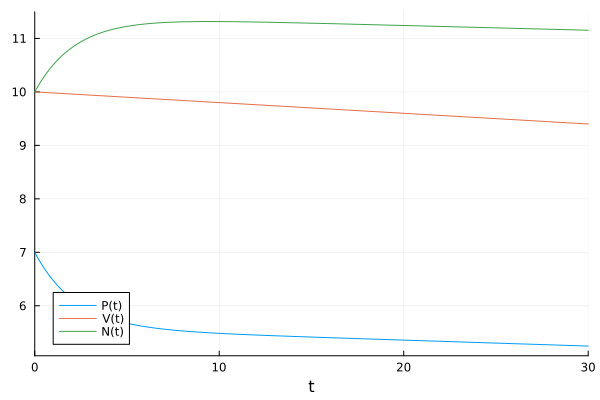

In [285]:
prob_vs = ODEProblem(sys, u0, tspan, ps)
sol = solve(prob_vs)
plot(sol)

In [286]:
eqs_v = [  D(P) ~ e * ( V - P )  - r * P
           D(N) ~ r * P  - e *( V - P) + D(V)
           D(V) ~ dvu(t)
        ]

3-element Vector{Equation}:
 Differential(t)(P(t)) ~ e*(V(t) - P(t)) - r*P(t)
 Differential(t)(N(t)) ~ Differential(t)(V(t)) - e*(V(t) - P(t)) + r*P(t)
 Differential(t)(V(t)) ~ dvu(t)

In [287]:
@named sysv = ODESystem(eqs_v, t)
sysv = structural_simplify(sysv)

Model sysv with 3 equations
States (3):
  P(t)
  V(t)
  N(t)
Parameters (2):
  r
  e
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 7 stored entries:
 ×  ×  ⋅  ×  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ×  ⋅
 ×  ×  ⋅  ⋅  ⋅  ×

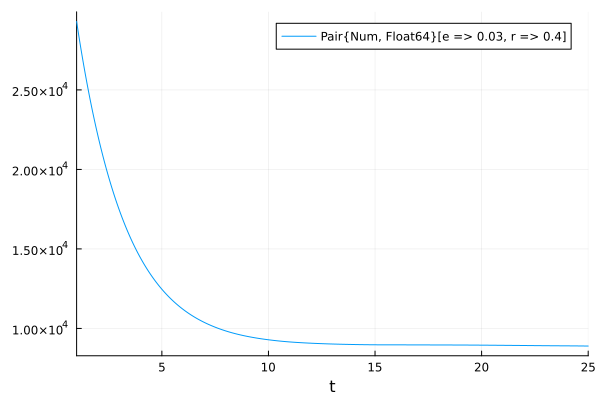

In [300]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => 0.03, r=> 0.4]
tspan=(1,length(year)-1) # 短くしないとエラー
probv = ODEProblem(sysv, u0, tspan, ps)
solv = solve(probv)
plot(solv, idxs=[P],label="$ps")

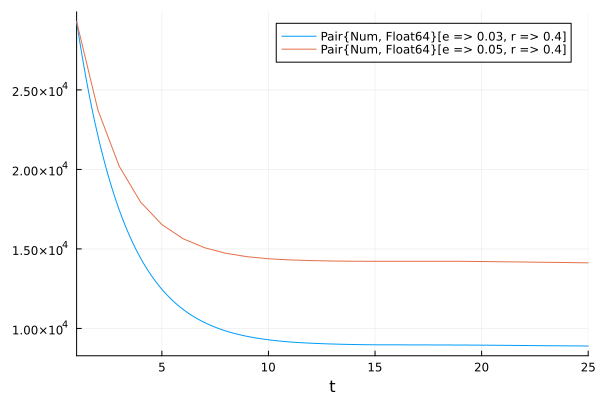

In [301]:
us=[P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps=[e=> 0.05, r=>0.4]
rprob=remake(probv ; u0 = us , p=ps) 
rsolv=solve(rprob, saveat=collect(0:25))
plot!(rsolv, idxs=[P], label="$ps")

In [302]:
rsolv.u[2][1]

23732.698927192952

In [303]:
using Turing, Distributions

In [311]:
@model function findprm(prob, Px, Vx, ts) # findprm(Pu, Vu, probv)
    n = length(Px)
    entry  ~ truncated(TDist(3), 1e-3, 1 - 1e-3)
    retire ~ truncated(TDist(3), 1e-3, 1 - 1e-3 )
    s ~ InverseGamma(2,3)
    
    prob = remake(prob ; 
            u0= [ P => Px[1], N => Vx[1] - Px[1], V => Vx[1] ],
            p = [ e => entry, r => retire],
            tspan = ts
    )
    solv = solve(prob, saveat=collect(ts[1]:ts[end]) )
    
    for i = 1:n-1 #　nまでやるとエラー
        Px[i] ~ Normal(solv.u[i][1], s) 
    end
    return (; Ps = [])
end
    

findprm (generic function with 2 methods)

In [312]:
ts = ( 1,length(year)-1 ) #(1.0, 24.0 )
model = findprm(probv, Pu, Vu, ts)
chain = sample(model, NUTS(.64), 2000, progress=false)

┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\UCuzt\src\mcmc\hmc.jl:192


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 379.57 seconds
Compute duration  = 379.57 seconds
parameters        = entry, retire, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters        mean        std      mcse   ess_bulk   ess_tail      rhat  ⋯
      Symbol     Float64    Float64   Float64    Float64    Float64   Float64  ⋯

       entry      0.0040     0.0020    0.0003    76.8731    41.2806    1.0127  ⋯
      retire      0.0735     0.0125    0.0017    74.5979    30.5071    1.0130  ⋯
           s   1853.3453   270.7852   21.5890   173.2478   263.8985    0.9997  ⋯
                                                                1 column omitted

Quantiles
  parameters        2.5%       25.0%      

In [313]:
rs = get(chain, [:entry, :retire])
ts_0 = (; e = rs[:entry]  |> mean, r = rs[:retire] |> mean)

(e = 0.004048579387182518, r = 0.07351693237458486)

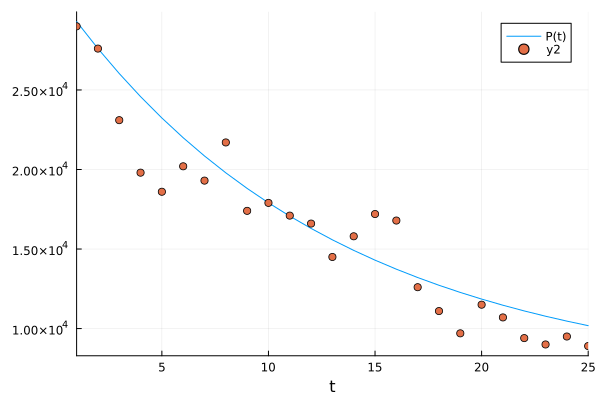

In [314]:
rsol =solve( remake( probv, p = [e => ts_0.e, r => ts_0.r]) , saveat=collect(ts[1]:ts[end]))
plot(rsol, idxs=[P])
scatter!(0:ts[2], Pu)

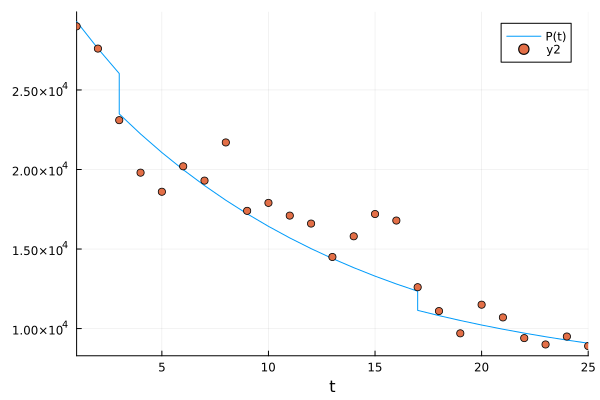

In [317]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_0.e, r => ts_0.r ]
tspan=(1,length(year)-1)
event_10 = ( t == 3 ) => [ P ~ P * 0.95 ] 
event_16 = ( t == 17 ) => [ P ~ P * 0.95 ] 
@named sys_cata = ODESystem(eqs_v, t, [P,N,V], [e,r] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) 
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol = solve(prob_cata, saveat=collect(ts[1]:ts[end]), tstops = [3, 17.0])
plot(sol, idxs=[P] )
scatter!(0:ts[2], Pu)

In [323]:
prob_remake_solve(prob, us, ps, ts)= begin
    rprob = remake(prob,u0=us, p=ps, tspan=ts)
    sol =solve(rprob ; saveat=collect(ts[1]:ts[end]) , tstops = [3.0, 17.0] )
    return sol
end
@model function findprmevent(prob, Px, Vx, ts ) # findprm(Pu, Vu, probv)
    n = length(Px)
    entry  ~ truncated(TDist(3), 1e-4, 1 - 1e-4)
    retire ~ truncated(TDist(3), 1e-4, 1 - 1e-4 )
    s ~ InverseGamma(2,3)
    
    u0= [ P => Px[1], N => Vx[1] - Px[1], V => Vx[1] ]
    p = [ e => entry, r => retire]
    solv=prob_remake_solve(prob, u0, p, ts)

    # t が繰り返される
    countlist=collect(1:26) |> t-> [e > 3 ? e + 3 : e for e in t] |> t->[e > 17 ? e + 3 : e for e in t]
    countlist[4] -= 1
    countlist[17] -= 1
    
    for (i,e) in enumerate(countlist) #最後までやるとエラー
        Px[i] ~ Normal(solv.u[e][1], s) 
    end
    return (; Ps = [])
end
    

    

findprmevent (generic function with 2 methods)

In [324]:
ts =  (1, 24 )
model = findprmevent(prob_cata, Pu, Vu, ts)
chain = sample(model, NUTS(.64), 2000, progress=false)

BoundsError: BoundsError: attempt to access 30-element Vector{Vector{Float64}} at index [31]

In [52]:
ts_2 = get(chain, [:entry, :retire]) |> t-> (; e = mean(t.entry), r = mean(t.retire) )

(e = 0.001138556508419439, r = 0.03420335127787648)

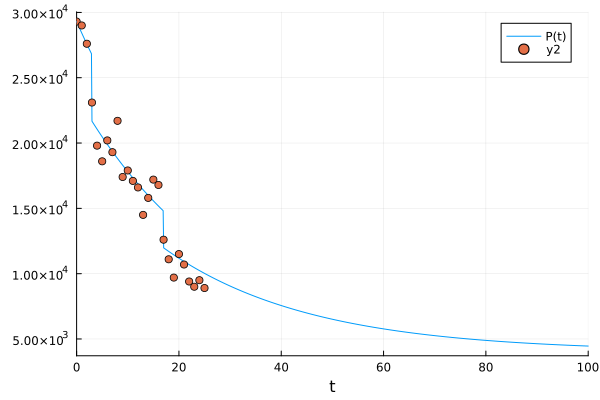

In [53]:
rsol =solve( remake( prob_cata, p = [e => ts_2.e, r => ts_2.r]) ; tstops = [3, 17.0] )
plot(rsol, idxs=[P])
scatter!(0:ts[2], Pu)

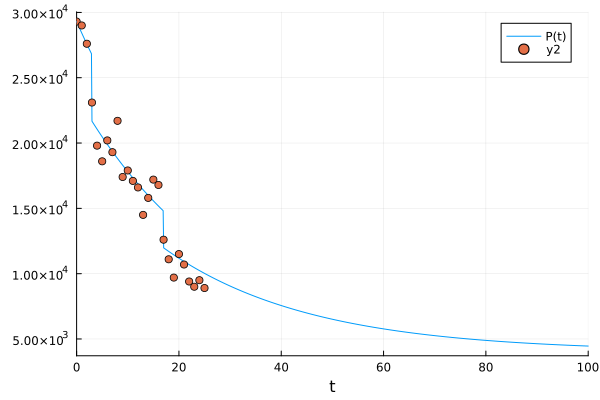

In [54]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_2.e, r => ts_2.r , b => -0.02]
tspan=(0, 100)
event_10 = (t == 3 ) => [ P ~ P * 0.9 ] 
event_16 = (t == 17 ) => [ P ~ P * 0.9 ]

@named sys_cata = ODESystem(eqs, t, [P,N,V], [e,r,b] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) 
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol = solve(prob_cata, tstops = [3, 17.0])
plot(sol, idxs=[P] )
scatter!(0:ts[2], Pu)

In [55]:
sol

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 20-element Vector{Float64}:
   0.0
   0.22235905640436143
   2.445949620447976
   3.0
   3.0
   3.0
   3.0
   7.632466449606175
  16.401394955185026
  17.0
  17.0
  17.0
  17.0
  22.632353178251716
  32.20581822503901
  43.46759008213685
  57.625028605515595
  74.03287591341656
  93.32834373227854
 100.0
u: 20-element Vector{Vector{Float64}}:
 [29300.0, 125265.0, 95965.0]
 [29102.234447499388, 125264.99555281887, 96162.76110531949]
 [27207.75411528487, 125264.95108100759, 98057.19696572272]
 [26758.426593287208, 125264.94, 98506.5134067128]
 [24082.58393395849, 125264.94, 98506.5134067128]
 [24082.58393395849, 125264.94, 98506.5134067128]
 [21674.32554056264, 125264.94, 98506.5134067128]
 [19010.49712196842, 125264.84735067101, 101170.24917597802]
 [15019.839136753617, 125264.6719721009, 105160.73178262271]
 [14789.896243561054, 125264.66, 105390.662

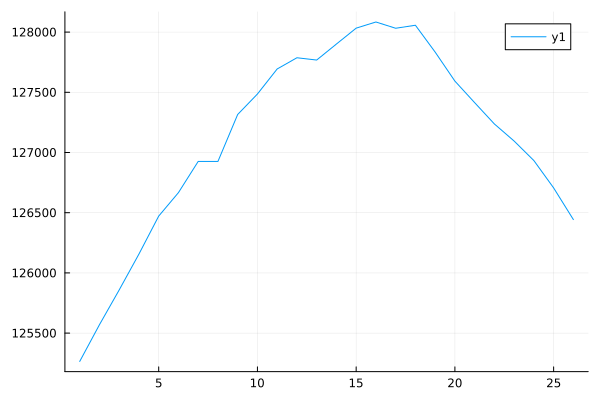

In [56]:
plot(Vu)

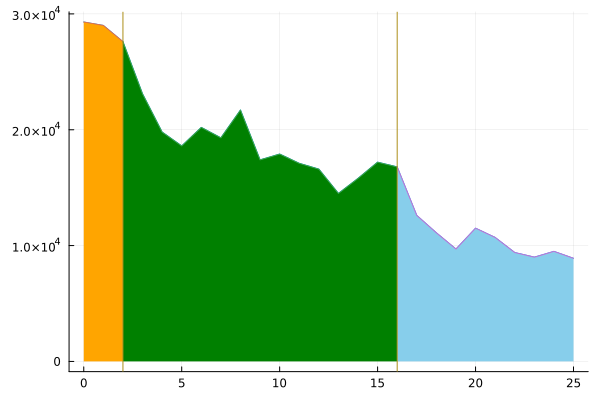

In [57]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:orange, 0))
plot!(2:16,Pu[3:17],fill=(:green, 0))
plot!(16:25, Pu[17:26],fill=(:skyblue, 0))
vline!([2,16])

In [60]:
model = findprm(probv,Pu[1:3], Vu[1:3], (0,2) )
chain = sample(model, NUTS(), 2000,progress=false)

┌ Info: Found initial step size
│   ϵ = 2.44140625e-5
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\UCuzt\src\mcmc\hmc.jl:192


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 324.22 seconds
Compute duration  = 324.22 seconds
parameters        = entry, retire, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean        std      mcse   ess_bulk   ess_tail      rhat   ⋯
      Symbol    Float64    Float64   Float64    Float64    Float64   Float64   ⋯

       entry     0.0740     0.0661    0.0051   157.4653   282.6809    1.0250   ⋯
      retire     0.2763     0.2239    0.0172   157.8957   286.4517    1.0264   ⋯
           s   406.5820   200.7297   16.4955   162.2097   334.5280    1.0136   ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50

In [61]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_1 = (; e=ec, r=rc)

(e = 0.07403921324355658, r = 0.27634968962831624)

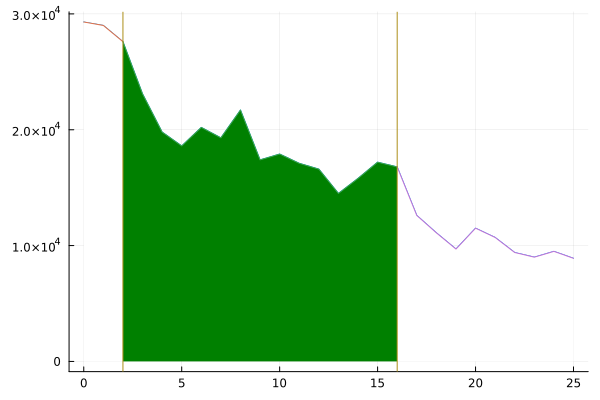

In [62]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:white, 0))
plot!(2:16,Pu[3:17],fill=(:green, 0))
plot!(16:25, Pu[17:26],fill=(:white, 0))
vline!([2,16])

In [64]:
ts = (2,16)
model = findprm(probv,Pu[3:17], Vu[3:17], ts)
chain = sample(model, NUTS(), 2000,progress=false)

┌ Info: Found initial step size
│   ϵ = 4.8828125e-5
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\UCuzt\src\mcmc\hmc.jl:192


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 1472.8 seconds
Compute duration  = 1472.8 seconds
parameters        = entry, retire, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters        mean        std      mcse   ess_bulk   ess_tail      rhat  ⋯
      Symbol     Float64    Float64   Float64    Float64    Float64   Float64  ⋯

       entry      0.0722     0.0272    0.0013   446.9638   661.0292    1.0132  ⋯
      retire      0.4608     0.1588    0.0077   448.2809   687.8478    1.0128  ⋯
           s   1573.8710   301.7385   13.4548   552.8402   596.5309    1.0018  ⋯
                                                                1 column omitted

Quantiles
  parameters        2.5%       25.0%      

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_2 = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[3], V => Vu[3], N => Pu[3]+Vu[3] ]
ptest = [ e => ts_2.e, r => ts_2.r ]
ttest = (2,16)
tsolv = remake(probv, u0=utest, p=ptest, tspan=ttest ) |> solve
plot(2:16, Pu[3:17])
plot!(tsolv, idxs=[P])

In [ ]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:white, 0))
plot!(2:16,Pu[3:17],fill=(:white, 0))
plot!(16:25, Pu[17:26],fill=(:skyblue, 0))
vline!([2,16])

In [ ]:
model = findprm(probv,Pu[17:26], Vu[17:26], (16,25) )
chain = sample(model, NUTS(), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_3 = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[17], V => Vu[17], N => Pu[17]+Vu[17] ]
ptest = [ e => ts_3.e, r => ts_3.r ]
ttest = (16,25)
tsolv = remake(probv, u0=utest, p=ptest, tspan=ttest) |> solve
plot(16:25, Pu[17:26])
plot!(tsolv, idxs=[P])

In [ ]:
u0 = [P => Pu[1] , N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_1.e, r => ts_1.r ]
tspan=(0,25)

inverse_func  = [ (t >  2.0 ) =>  [ e ~ ts_2.e, r ~ ts_2.r] ,
                  (t > 16.0 ) =>  [ e ~ ts_3.e, r ~ ts_3.r] ]

@named syv = ODESystem(eqs_v, t ;  discrete_events = inverse_func )
syv = structural_simplify(syv)

In [ ]:
prob_cr = ODEProblem(syv, u0, tspan, ps)
solcr = solve(prob_cr);
plot(solcr, idxs=[P])
plot!(0:tspan[2],Pu,label="Observed")
vline!([2,16], 
label="1996 & 2011")

In [ ]:
noize = [0.05*P, 0.05*V, 0.05*N]

In [ ]:
#@named de = SDESystem(eqs_v, noize, t, [P,N, V], [e,r]; tspan=tspan)
@named de = SDESystem(sysv, noize)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_1.e, r => ts_1.r ]
tspan=(0,length(year)-1)

In [ ]:
probe = SDEProblem(de, u0, tspan, ps)

In [ ]:
sole = solve(probe);
plot(sole,idxs=[P])
plot!(0:tspan[2],Pu)

In [ ]:
eqs_v

In [ ]:
catastrophe = [ [t ~  3.0]  =>  [ P ~ 0.8 * P ] 
                [t ~ 16.0]  =>  [ P ~ 0.9 * P ] ]

@named sys_cata = ODESystem(eqs_v, t ;  
       # discrete_events = catastrophe, 
        continuous_events = catastrophe )
sys_cata = structural_simplify(sys_cata)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => 0.03, r => 0.04 ]
tspan=(0,length(year)-1)
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)

In [ ]:
solc = solve(prob_cata);
plot(solc,idxs=[P])
plot!(0:tspan[2],Pu)
plot!(solv, idxs=[P])

In [ ]:
model = findprm(prob_cata, Pu, Vu, (0,25) )
c_cata = sample(model, NUTS(), 2000)

In [ ]:
rs = get(c_chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_ct = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[1], V => Vu[1], N => Pu[1]+Vu[1] ]
ptest = [ e => ts_ct.e, r => ts_ct.r ]
ttest = (0,25)
tsolv = remake(prob_ct, u0=utest, p=ptest, tspan=ttest) |> solve
plot(0:25, Pu)
plot!(tsolv, idxs=[P])

In [ ]:
ts_3

カタストロフィーに対して行動の変化が持続的である前提となっている。
もしかするとカタストロフィーイベントによってボリュームが一度に離脱したかもしれない